In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

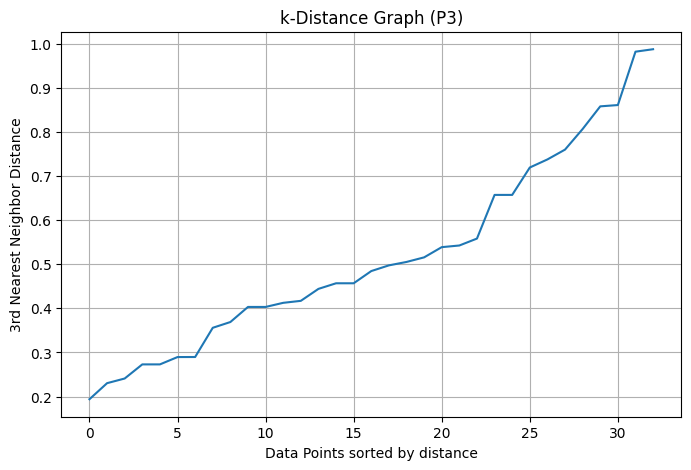

In [3]:
# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/erp_features.csv')

# 2. Create save path
save_path = '/content/drive/MyDrive/dbscan_clustering_P3_copy'
os.makedirs(save_path, exist_ok=True)

# 3. Select P3 features
features = df[['Latency_P3 (ms)', 'Amplitude_P3 (µV)']].copy()

# 4. Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Save scaler
import joblib
joblib.dump(scaler, f'{save_path}/scaler_P3.pkl')

# 5. Plot k-distance graph (for selecting eps)
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort the distances to see the 'elbow'
sorted_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title('k-Distance Graph (P3)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('3rd Nearest Neighbor Distance')
plt.grid(True)
plt.savefig(f'{save_path}/k_distance_graph_P3.png')
plt.show()

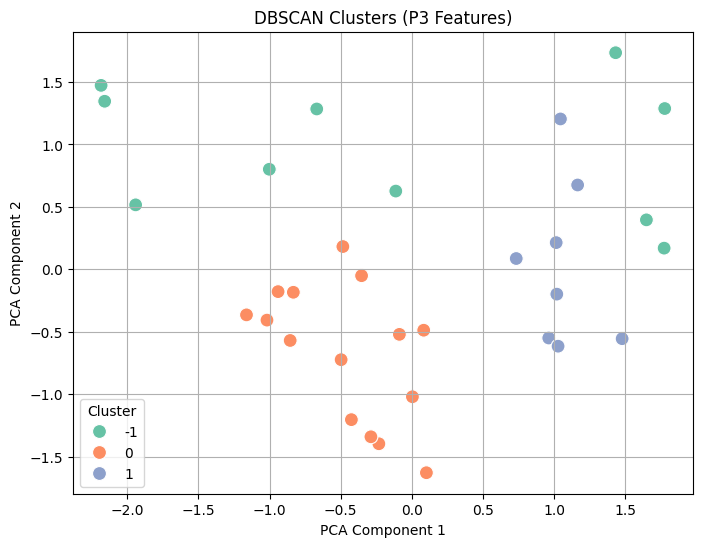

In [4]:
# 6. Run DBSCAN (after inspecting the k-distance plot, adjust eps accordingly)
eps = 0.55
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_features)

# 7. Add cluster labels to original dataframe
df['Cluster_P3_DBSCAN'] = dbscan_labels

# 8. Save clustered data
df.to_csv(f'{save_path}/clustered_P3.csv', index=False)

# 9. Evaluate clustering (ignore noise points, which are labeled as -1)
core_samples_mask = dbscan_labels != -1
if len(set(dbscan_labels)) > 1 and sum(core_samples_mask) > 1:
    sil_score = silhouette_score(scaled_features[core_samples_mask], dbscan_labels[core_samples_mask])
    dbi_score = davies_bouldin_score(scaled_features[core_samples_mask], dbscan_labels[core_samples_mask])
else:
    sil_score = -1
    dbi_score = -1

# Save evaluation
with open(f'{save_path}/evaluation_P3.txt', 'w') as f:
    f.write(f'eps: {eps}\n')
    f.write(f'min_samples: {min_samples}\n')
    f.write(f'Silhouette Score (excluding noise): {sil_score:.4f}\n')
    f.write(f'Davies-Bouldin Index (excluding noise): {dbi_score:.4f}\n')

# 10. PCA for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=dbscan_labels, palette='Set2', s=100)
plt.title('DBSCAN Clusters (P3 Features)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(f'{save_path}/cluster_plot_P3.png')
plt.show()

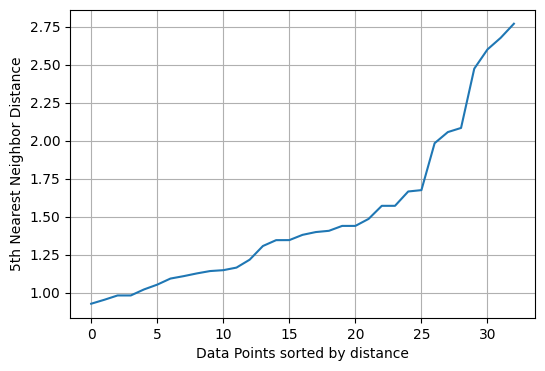

In [5]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/erp_features.csv')

# Save path
save_path = '/content/drive/MyDrive/dbscan_P3_N1_copy'
os.makedirs(save_path, exist_ok=True)

# Select features: P3 + N1
features = df[['Latency_P3 (ms)', 'Amplitude_P3 (µV)', 'Latency_N1 (ms)', 'Amplitude_N1 (µV)']].copy()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Save scaler
import joblib
joblib.dump(scaler, f'{save_path}/scaler_P3_N1.pkl')

# Step 1: Plot k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot the elbow
plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(True)
plt.savefig(f'{save_path}/k_distance_plot_P3_N1.png')
plt.show()

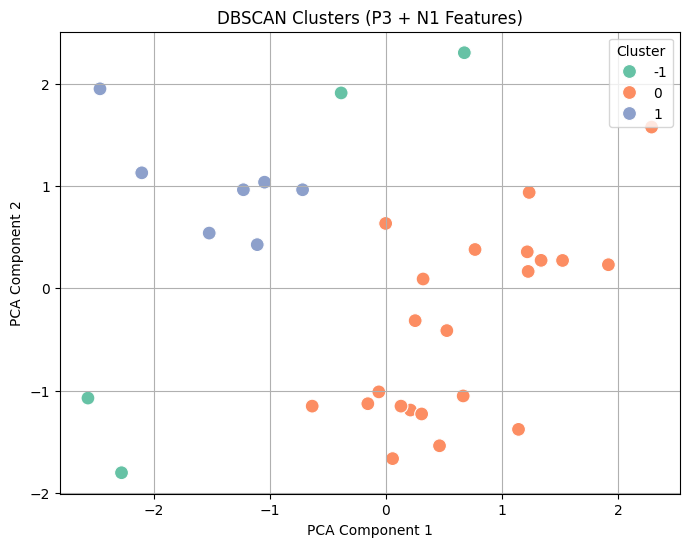

In [6]:
# Step 2: DBSCAN
eps = 1.65
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_features)

# Add cluster labels
df['Cluster_P3_N1_DBSCAN'] = clusters

# Save clustered dataset
df.to_csv(f'{save_path}/clustered_P3_N1.csv', index=False)

# Step 3: Evaluation (ignore noise points for silhouette if needed)
if len(set(clusters)) > 1 and len(set(clusters)) != 1 + (1 if -1 in clusters else 0):
    sil_score = silhouette_score(scaled_features, clusters)
    dbi_score = davies_bouldin_score(scaled_features, clusters)
else:
    sil_score = dbi_score = float('nan')  # Not valid with 1 cluster or all noise

# Save evaluation
with open(f'{save_path}/evaluation_P3_N1.txt', 'w') as f:
    f.write(f'Silhouette Score: {sil_score:.4f}\n')
    f.write(f'Davies-Bouldin Index: {dbi_score:.4f}\n')
    f.write(f'Unique Clusters Found: {set(clusters)}\n')

# Step 4: Visualize with PCA
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=clusters, palette='Set2', s=100)
plt.title('DBSCAN Clusters (P3 + N1 Features)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(f'{save_path}/dbscan_cluster_plot_P3_N1.png')
plt.show()

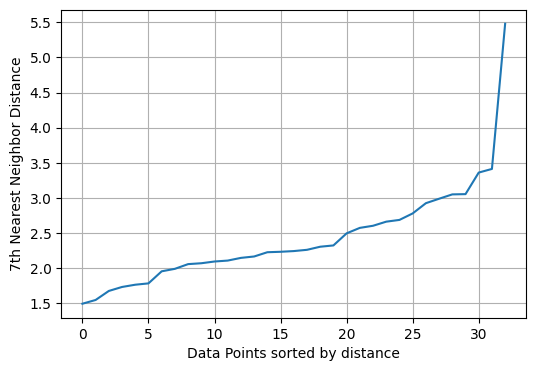

In [7]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/erp_features.csv')

# Save path
save_path = '/content/drive/MyDrive/dbscan_P3_N1_P1_copy'
os.makedirs(save_path, exist_ok=True)

# Select features: P3 + N1
features = df[['Latency_P3 (ms)', 'Amplitude_P3 (µV)',
               'Latency_N1 (ms)', 'Amplitude_N1 (µV)',
               'Latency_P1 (ms)', 'Amplitude_P1 (µV)']].copy()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Save scaler
import joblib
joblib.dump(scaler, f'{save_path}/scaler_P3_N1_P1.pkl')

# Step 1: Plot k-distance graph
neighbors = NearestNeighbors(n_neighbors=7)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot the elbow
plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('7th Nearest Neighbor Distance')
plt.grid(True)
plt.savefig(f'{save_path}/k_distance_plot_P3_N1_P1.png')
plt.show()

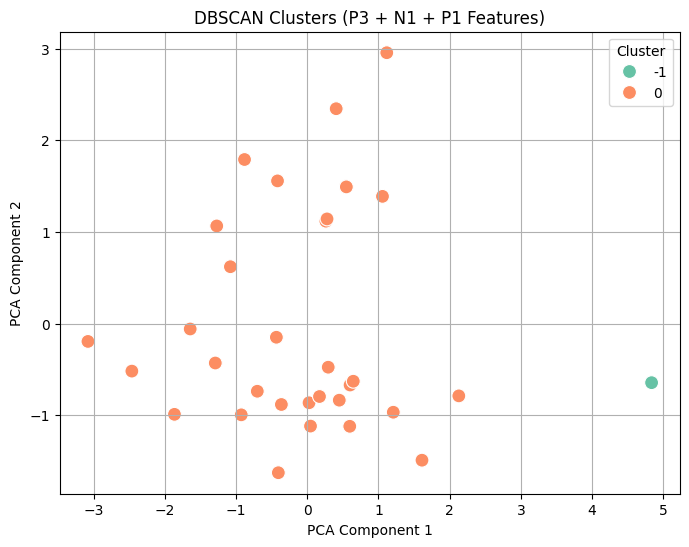

In [8]:
# Step 2: DBSCAN
eps = 3.4
min_samples = 7

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_features)

# Add cluster labels
df['Cluster_P3_N1_P1_DBSCAN'] = clusters

# Save clustered dataset
df.to_csv(f'{save_path}/clustered_P3_N1_P1.csv', index=False)

# Step 3: Evaluation (ignore noise points for silhouette if needed)
if len(set(clusters)) > 1 and len(set(clusters)) != 1 + (1 if -1 in clusters else 0):
    sil_score = silhouette_score(scaled_features, clusters)
    dbi_score = davies_bouldin_score(scaled_features, clusters)
else:
    sil_score = dbi_score = float('nan')  # Not valid with 1 cluster or all noise

# Save evaluation
with open(f'{save_path}/evaluation_P3_N1_P1.txt', 'w') as f:
    f.write(f'Silhouette Score: {sil_score:.4f}\n')
    f.write(f'Davies-Bouldin Index: {dbi_score:.4f}\n')
    f.write(f'Unique Clusters Found: {set(clusters)}\n')

# Step 4: Visualize with PCA
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=clusters, palette='Set2', s=100)
plt.title('DBSCAN Clusters (P3 + N1 + P1 Features)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(f'{save_path}/dbscan_cluster_plot_P3_N1_P1.png')
plt.show()